In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Modelo Rede Neueral Convolucional U-Net



In [1]:
import os
from sklearn.preprocessing import LabelEncoder
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
from PIL import Image
import tifffile as tiff

# Importar dados treino


In [2]:
n_classes= 6 #Numero de classes
#num_images = 696  #Total 58 images data augmented to 696

Importar imagens de treinamento

In [5]:
# Importar e criar dataset de imagens
file_name = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_images/*.tif")
file_name.sort()
print(len(file_name))
images = []
for image in file_name: # para cada imagem no diretorio
    img = Image.open(image).convert('L') # ler e converter a imagem para escala de cinza
    # para verificar se todas imagens estao no mesmo shape. pre-processamento
    if img.size != (256, 256):
        print(image)
        print(img.size)
    images.append(np.array(img)) # adicionar à lista
train_image_dataset = np.array(images) # criar array

336


Importar masks de treinamento

In [6]:
# Importar e criar dataset de masks
file_name_masks = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_masks/*.tif")
file_name_masks.sort()
print(len(file_name_masks))
masks = []
for mask in file_name_masks: # para cada imagem no diretorio
    img = Image.open(mask)#.convert('L') # ler e converter a imagem para escala de cinza # nao precisa converter para cinza pois essa ja é escala de cinza, e estava retirando o formato tiff de algumas imagens
    img = np.array(img)  # Converter para matriz NumPy
    # para verificar se todas masks estao no mesmo shape
    if img.shape != (256, 256):
        print(mask)
        print(img.shape)

    img = np.array(img)
    #img[img > 5] = 0 # modificar os valores dos pixels conforme a condição

    masks.append(img) # adicionar à lista de masks

train_mask_dataset = np.array(masks) # criar array das masks


336


Visualizar os dados
> numero de imagens e masks deve ser igual



> ambas devem ser no máximo 256x256 pixels

> len(masks) = n_classes

In [7]:
unique_mask, mask_count = np.unique(train_mask_dataset, return_counts=True)

print("Image data shape is: ", train_image_dataset.shape)
print("Mask data shape is: ", train_mask_dataset.shape)
print("Max pixel value in image is: ", train_image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)


Image data shape is:  (336, 256, 256)
Mask data shape is:  (336, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5]
Count of each label: [ 444204  298674 6515172 7479820 1481436 5800790]


Codificar labels para 0, 1, 2, 3, ... matrizes multidimencionais precisam ser achatadas, codificadas e 'reshapadas'


In [8]:
labelencoder = LabelEncoder()
n, h, w = train_mask_dataset.shape
mask_dataset_reshaped = train_mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [9]:
#Normalizar o valor dos pixels das imagens, entre 0 e 1
image_dataset = train_image_dataset /255.

# Importar dados de Validação

In [10]:
# Importar e criar dataset de imagens
file_name = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_images/*.tif")
file_name.sort()
print(len(file_name))
images = []
for image in file_name: # para cada imagem no diretorio
    img = Image.open(image).convert('L') # ler e converter a imagem para escala de cinza
    # para verificar se todas imagens estao no mesmo shape. pre-processamento
    if img.size != (256, 256):
        print(image)
        print(img.size)
    images.append(np.array(img)) # adicionar à lista
val_image_dataset = np.array(images) # criar array

132


In [12]:
# Importar e criar dataset de masks
file_name_masks = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_masks_corrigidas/*.tif")
file_name_masks.sort()
print(len(file_name_masks))
masks = []
for mask in file_name_masks: # para cada imagem no diretorio
    img = Image.open(mask)#.convert('L') # ler e converter a imagem para escala de cinza # nao precisa converter para cinza pois essa ja é escala de cinza, e estava retirando o formato tiff de algumas imagens
    img = np.array(img)  # Converter para matriz NumPy
    # para verificar se todas masks estao no mesmo shape
    if img.shape != (256, 256):
        print(mask)
        print(img.shape)

    #img = np.array(img)
    #img[img > 5] = 0 # modificar os valores dos pixels conforme a condição

    masks.append(img) # adicionar à lista de masks

val_mask_dataset = np.array(masks) # criar array das masks

132


In [13]:
unique_mask, mask_count = np.unique(val_mask_dataset, return_counts=True)

print("Validation image data shape is: ", val_image_dataset.shape)
print("Validartion mask data shape is: ", val_mask_dataset.shape)
print("Max pixel value in image is: ", val_image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)

Test image data shape is:  (132, 256, 256)
Test mask data shape is:  (132, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5]
Count of each label: [ 183966   43788 3383884 3831994  159590 1047530]


In [14]:
labelencoder = LabelEncoder()
n, h, w = val_mask_dataset.shape
val_mask_dataset_reshaped = val_mask_dataset.reshape(-1,1)
val_mask_dataset_reshaped_encoded = labelencoder.fit_transform(val_mask_dataset_reshaped)
val_mask_dataset_encoded = val_mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(val_mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [15]:
#Normalizar o valor dos pixels das imagens, entre 0 e 1
val_image_dataset = val_image_dataset /255.

# Create Model

Dividir os dados de treino e teste

In [16]:
X_train = image_dataset
X_val = val_image_dataset
y_train = mask_dataset_encoded
y_val = val_mask_dataset_encoded

In [ ]:
print(X_train.shape)
print(X_test.shape)

(336, 256, 256)
(396, 256, 256)


*Sanity check*, verificar alguns pares de imagens e masks


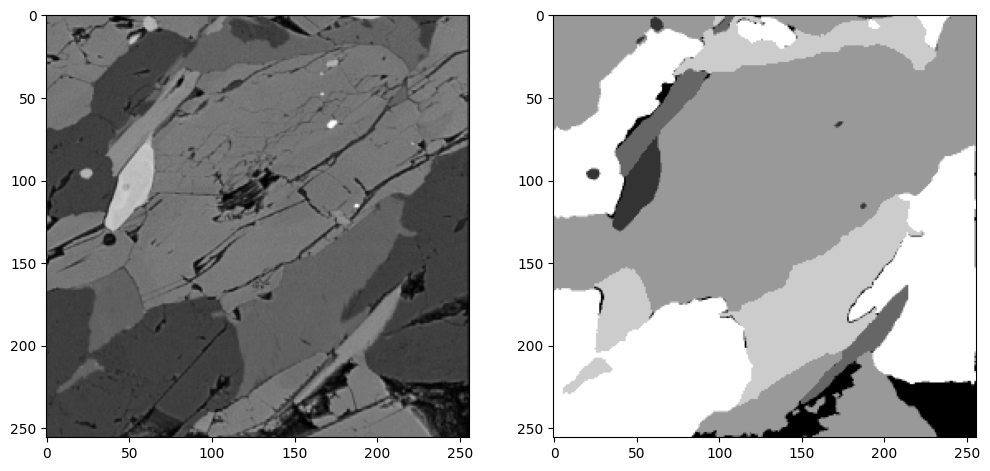

In [ ]:
import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

Transformar os dados em categóricos


In [17]:
from tensorflow.keras.utils import to_categorical
n_classes = 6
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [ ]:
print(train_masks_cat.shape)
print(y_train_cat.shape)

print(np.unique(val_masks_cat))
print(val_masks_cat.shape)
print(y_val_cat.shape)

(336, 256, 256, 6)
(336, 256, 256, 6)
[0. 1.]
(120, 256, 256, 6)
(120, 256, 256, 6)


## Construir modelo Unet



*   **Conv2D()** - seta azul escuro para direita -> convoluções e criação de features (camadas)
*   **MaxPool2D()** - seta para baixo -> redução espacial da feature segundo valor máximo
*   **conv_block()** - seta para cima -> convolução para reconstruir a feature (oposto a seta para baixo)
*   **Conv2DTranspose()** - seta cinza para direita -> concatena a posição antiga dos pixels com as features convolucionadas




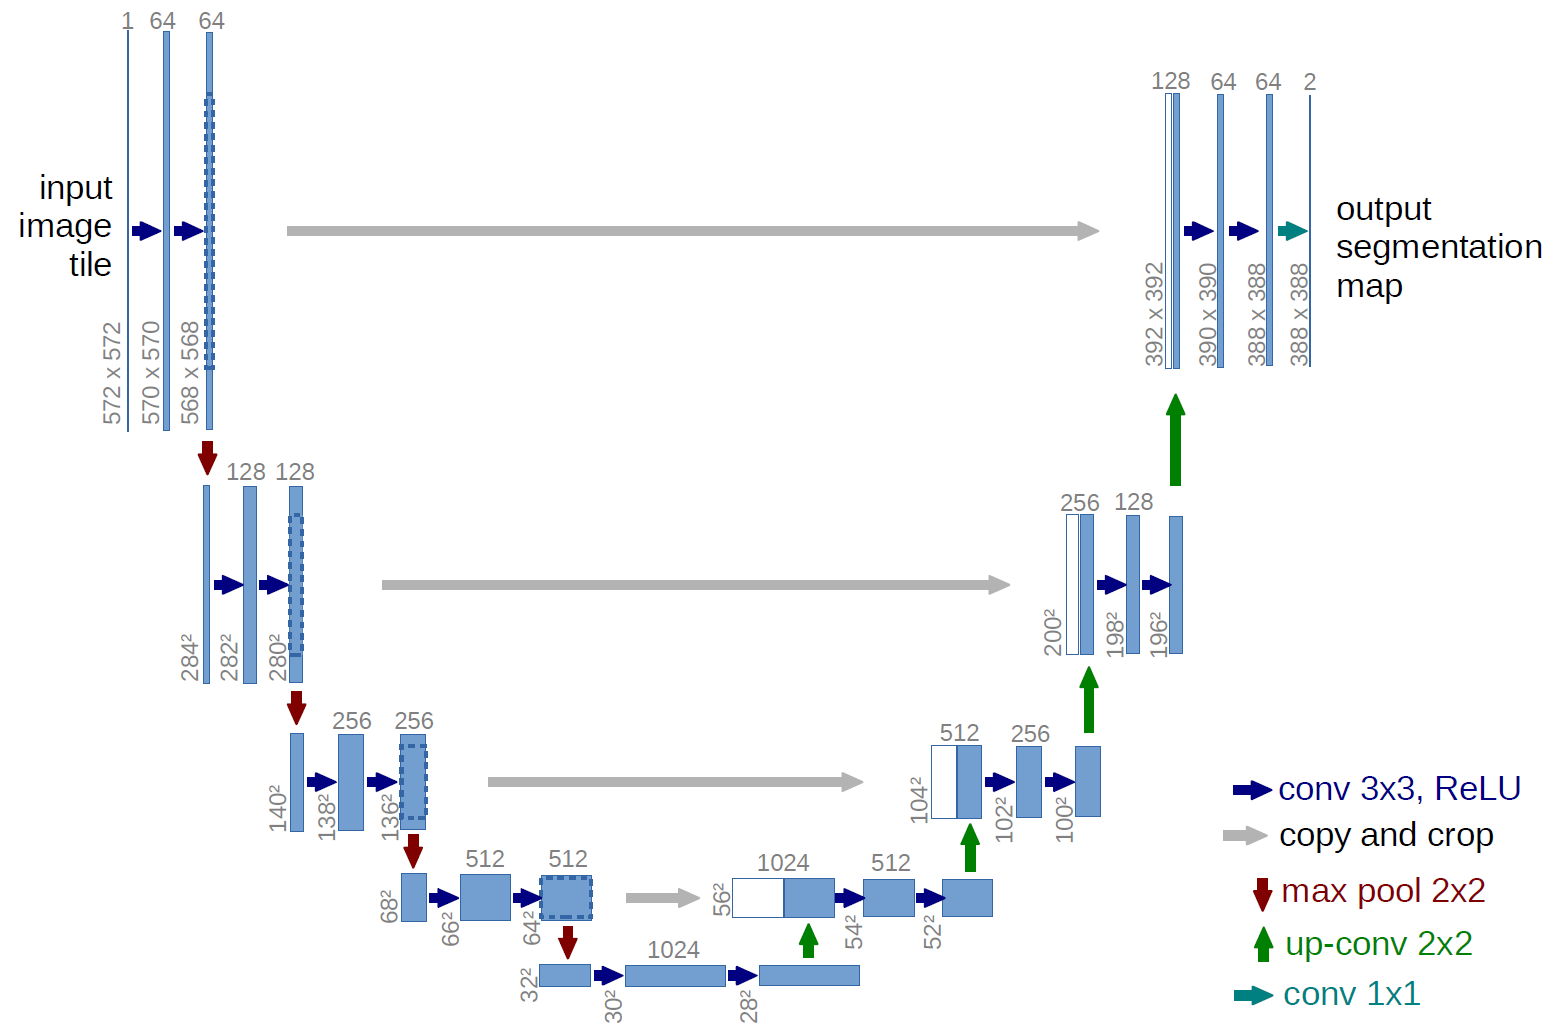

In [ ]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters): # Duas convoluções
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)   # ReLu como função de ativação

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters) # gerar features
    p = MaxPool2D((2, 2))(x)    # Reduz as imagens a aprtir de um kernel 2x2
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])   # utiliza a posição dos pixels do encoder
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    #Change the activation based on n_classes
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:               # mulsti-class classification
      activation = 'softmax'

    # Output convolution
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

## Modelo

Gerar pessos para as classes

>    Não Fui bem sucedido ao usar (até o momento)




In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes = np.unique(mask_dataset_reshaped_encoded),
                                                y = mask_dataset_reshaped_encoded)
print("Class weights are:", class_weights)

Class weights are: [ 8.26200575 12.28769829  0.56330301  0.49065566  2.47733685  0.6326752 ]


Transformar as classes de listas para dicionários

In [ ]:
class_weights2 = class_weights
lista = [0,1,2,3,4,5]
classWeights = dict(zip(lista, class_weights2))
print(classWeights)

{0: 8.262005745108103, 1: 12.287698293122267, 2: 0.563303010265884, 3: 0.49065565748908396, 4: 2.4773368542414254, 5: 0.6326752045842032}


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [ ]:
model = build_unet(input_shape, n_classes)
model.compile(optimizer='adam', # Adam como otimizador que utiliza backpropagation
              loss='categorical_crossentropy', # Função de custo # para classificação binária usar binary_crossentropy
              metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=150,
                    validation_data=(X_val, y_val_cat),
                    #class_weight=classWeights,
                    shuffle=True,
                    )

Epoch 1/150
42/42 [==============================] - 67s 736ms/step - loss: 0.5121 - accuracy: 0.8423 - val_loss: 1049.7213 - val_accuracy: 0.3397
Epoch 2/150
42/42 [==============================] - 29s 705ms/step - loss: 0.3289 - accuracy: 0.8962 - val_loss: 13.0469 - val_accuracy: 0.3396
Epoch 3/150
42/42 [==============================] - 26s 629ms/step - loss: 0.3825 - accuracy: 0.8797 - val_loss: 11.2823 - val_accuracy: 0.0772
Epoch 4/150
42/42 [==============================] - 27s 639ms/step - loss: 0.3494 - accuracy: 0.8859 - val_loss: 7.9686 - val_accuracy: 0.0682
Epoch 5/150
42/42 [==============================] - 30s 731ms/step - loss: 0.3045 - accuracy: 0.9021 - val_loss: 6.4322 - val_accuracy: 0.0673
Epoch 6/150
42/42 [==============================] - 27s 654ms/step - loss: 0.3047 - accuracy: 0.8985 - val_loss: 7.0675 - val_accuracy: 0.0712
Epoch 7/150
42/42 [==============================] - 28s 661ms/step - loss: 0.3025 - accuracy: 0.9034 - val_loss: 6.0469 - val_accu

In [ ]:
print(X_val.shape)
print(y_val_cat.shape)

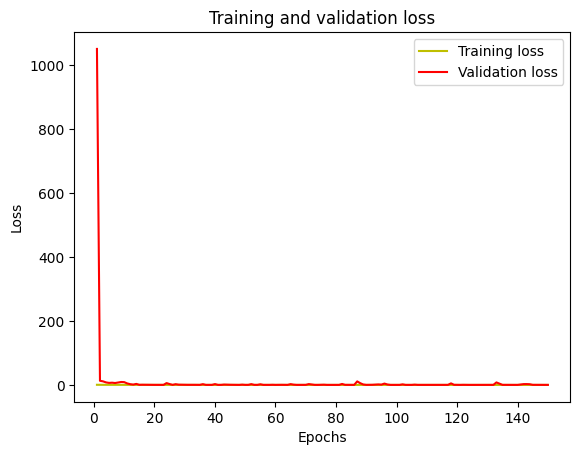

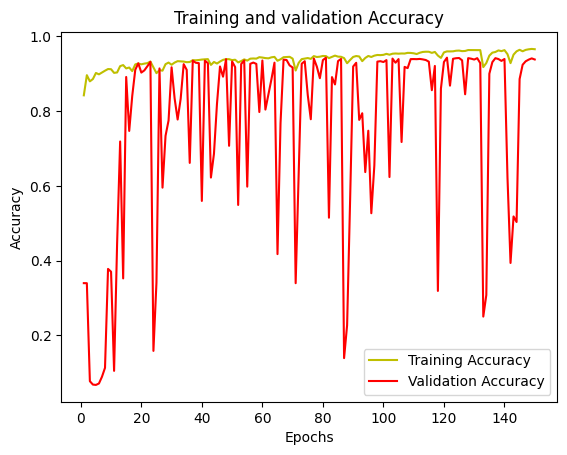

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Salvar modelos e history

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Modelos/Vit_28VAL+11x12_13-07.hdf5')

# Import Model

Carregar Modelo Salvo e History

In [18]:
#Load previously saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Modelos/Vit_28VAL+11x12_13-07.hdf5')

In [ ]:
# importar imagens de teste

# Importar e criar dataset de imagens de teste
file_name = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_images/*.tif")
file_name.sort()
print(len(file_name))
images = []
for image in file_name: # para cada imagem no diretorio
    img = Image.open(image).convert('L') # ler e converter a imagem para escala de cinza
    # para verificar se todas imagens estao no mesmo shape. pre-processamento
    if img.size != (256, 256):
        print(image)
        print(img.size)
    images.append(np.array(img)) # adicionar à lista
test_image_dataset = np.array(images) # criar array

In [ ]:
# Importar e criar dataset de masks
file_name_masks = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Teste/VIT_test_masks_corrigidas/*.tif")
file_name_masks.sort()
print(len(file_name_masks))
masks = []
for mask in file_name_masks: # para cada imagem no diretorio
    img = Image.open(mask)#.convert('L') # ler e converter a imagem para escala de cinza # nao precisa converter para cinza pois essa ja é escala de cinza, e estava retirando o formato tiff de algumas imagens
    img = np.array(img)  # Converter para matriz NumPy
    # para verificar se todas masks estao no mesmo shape
    if img.shape != (256, 256):
        print(mask)
        print(img.shape)

    #img = np.array(img)
    #img[img > 5] = 0 # modificar os valores dos pixels conforme a condição

    masks.append(img) # adicionar à lista de masks

test_mask_dataset = np.array(masks) # criar array das masks

In [ ]:
unique_mask, mask_count = np.unique(test_mask_dataset, return_counts=True)

print("Test image data shape is: ", test_image_dataset.shape)
print("Test mask data shape is: ", test_mask_dataset.shape)
print("Max pixel value in image is: ", test_image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)

In [ ]:
labelencoder = LabelEncoder()
n, h, w = test_mask_dataset.shape
test_mask_dataset_reshaped = test_mask_dataset.reshape(-1,1)
test_mask_dataset_reshaped_encoded = labelencoder.fit_transform(test_mask_dataset_reshaped)
test_mask_dataset_encoded = test_mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(test_mask_dataset_encoded)

In [ ]:
#Normalizar o valor dos pixels das imagens, entre 0 e 1
test_image_dataset = test_image_dataset /255.

In [ ]:
X_test = test_image_dataset
y_test = test_mask_dataset_encoded
print(X_test.shape)

Predição do modelo com os dados de teste

In [19]:
y_pred=model.predict(X_test)
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

5/5 [==============================] - 261s 49s/step


(132, 256, 256, 6)

(132, 256, 256)

# Métricas

In [21]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = n_classes
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.27508208


IoU de cada mineral

In [22]:
#To calculate I0U for 6 classes
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4]+ values[0,5]+ values[1,0]+ values[2,0]+ values[3,0]+ values[4,0]+ values[5,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4]+ values[1,5]+ values[0,1]+ values[2,1]+ values[3,1]+ values[4,1]+ values[5,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4]+ values[2,5]+ values[0,2]+ values[1,2]+ values[3,2]+ values[4,2]+ values[5,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4]+ values[3,5]+ values[0,3]+ values[1,3]+ values[2,3]+ values[4,3]+ values[5,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,5]+ values[0,4]+ values[1,4]+ values[2,4]+ values[3,4]+ values[5,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,4]+ values[0,5]+ values[1,5]+ values[2,5]+ values[3,5]+ values[4,5])

print("IoU para o fundo is: ", class1_IoU)
print("IoU para titanita is: ", class2_IoU)
print("IoU para biotita is: ", class3_IoU)
print("IoU para anfibólio is: ", class4_IoU)
print("IoU para k-feldspato is: ", class5_IoU)
print("IoU para plagioclásio is: ", class6_IoU)

IoU para o fundo is:  0.23234387
IoU para titanita is:  0.4723895
IoU para biotita is:  0.04707948
IoU para anfibólio is:  0.13064392
IoU para k-feldspato is:  0.041878533
IoU para plagioclásio is:  0.72615707


Testar algumas predições

1/1 [==============================] - 3s 3s/step


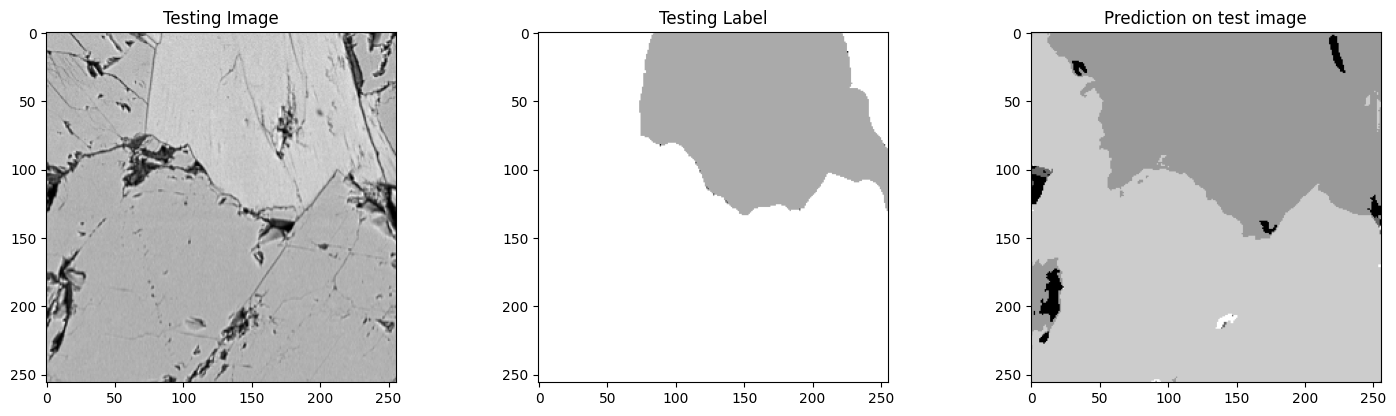

In [23]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

Confusion Matrix

In [24]:
y_test_lin = y_test.ravel()
y_pred_lin = y_pred_argmax.ravel()

print(y_test_lin.shape)
print(y_pred_lin.shape)
print(np.unique(y_test_lin))
print(np.unique(y_pred_lin))

(8650752,)
(8650752,)
[0 1 2 3 4 5]
[0 1 2 3 4 5]


<Axes: >

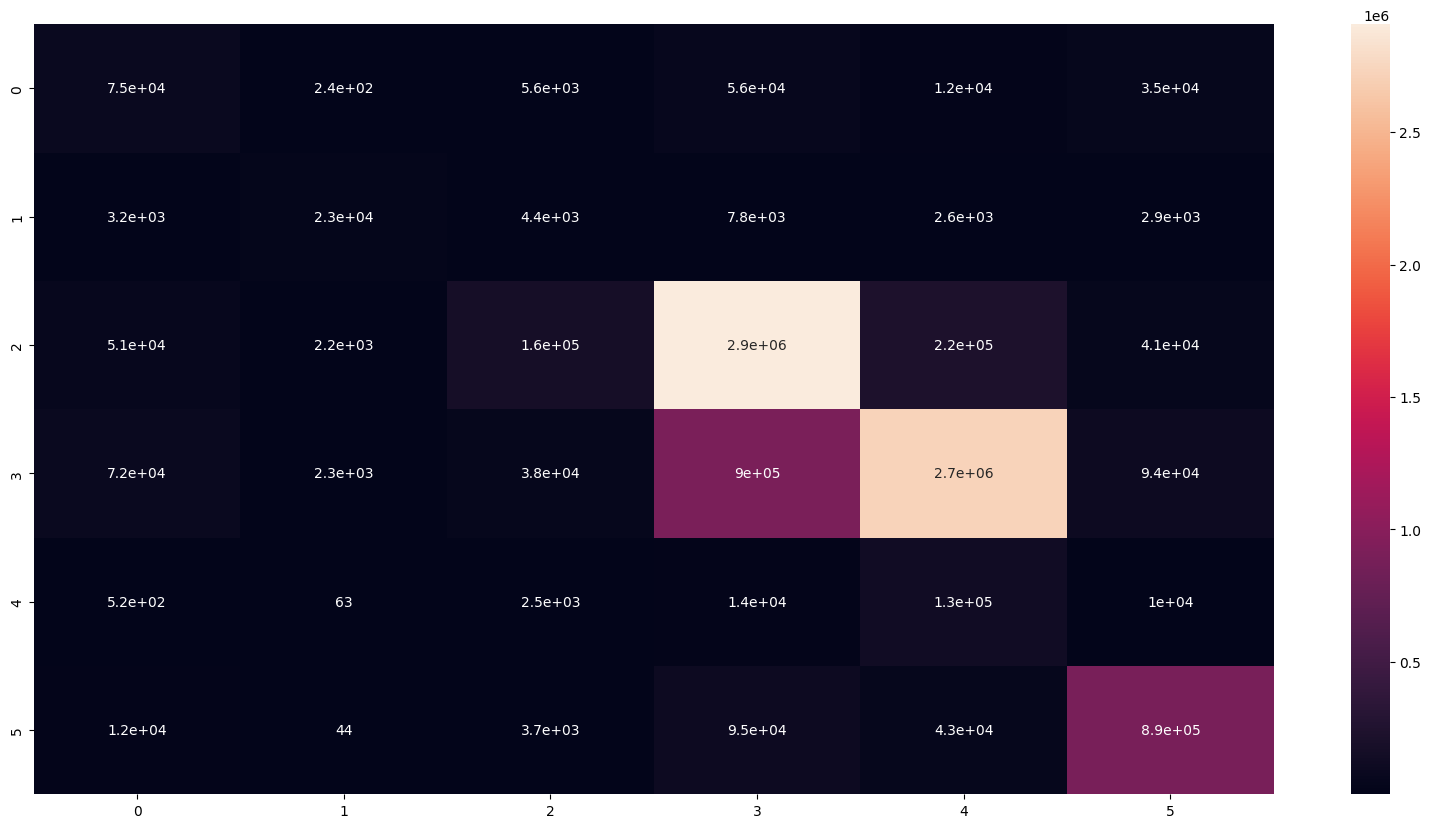

In [25]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.unique(y_pred_lin)
cm = confusion_matrix(y_test_lin, y_pred_lin, labels=labels)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True)

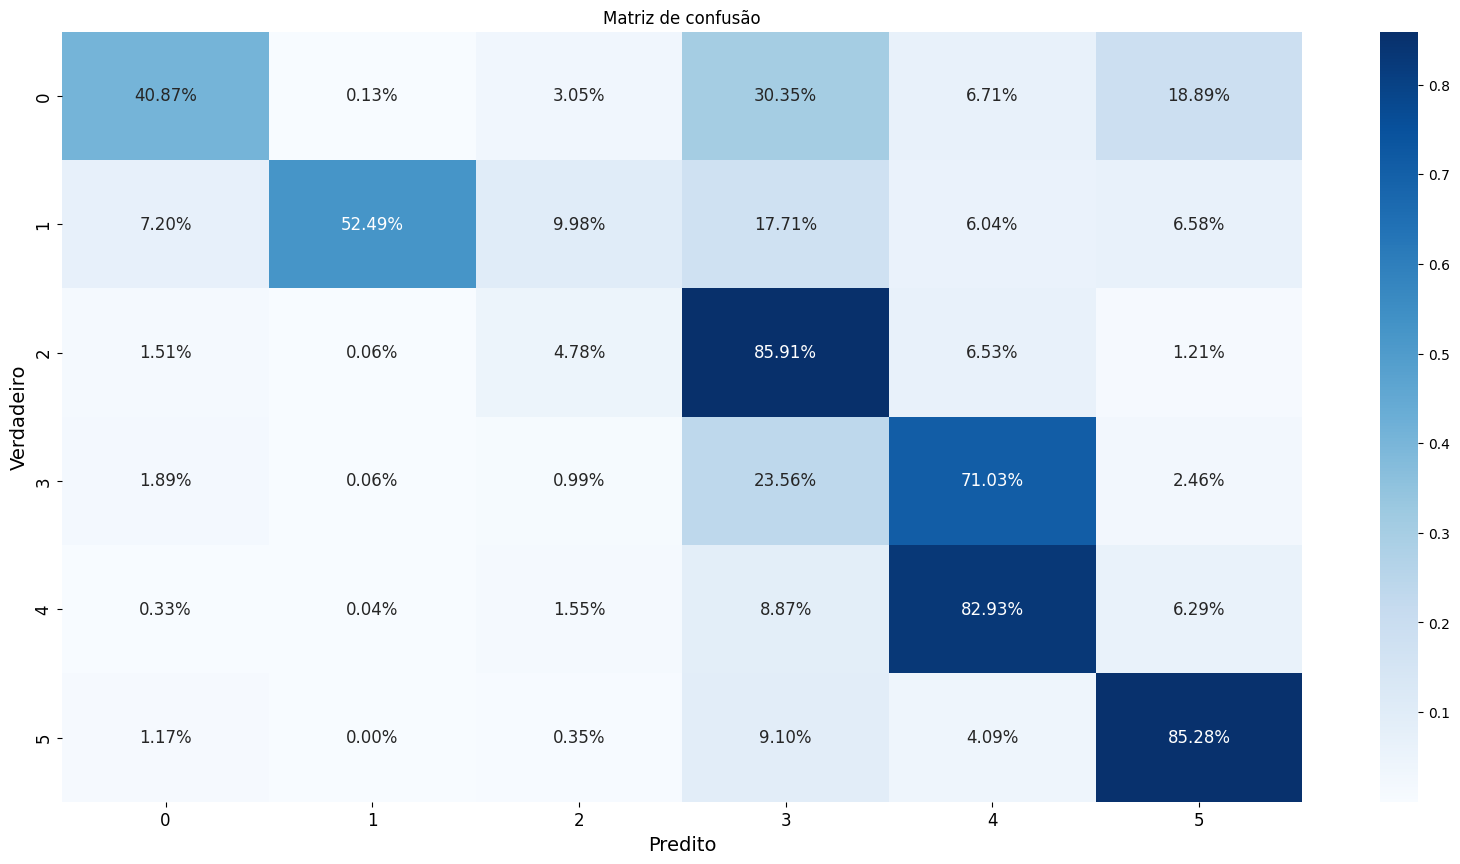

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.unique(y_pred_lin)
cm = confusion_matrix(y_test_lin, y_pred_lin, labels=labels)

# Converter a matriz de contagem em porcentagem
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 10))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues", annot_kws={"fontsize": 12})

plt.xticks(fontsize=12)  # Aumentar o tamanho da fonte para os valores do eixo x
plt.yticks(fontsize=12)  # Aumentar o tamanho da fonte para os valores do eixo y


plt.xlabel('Predito', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=14)

plt.title('Matriz de confusão')

plt.show()


In [ ]:
print(y_pred[:,:,:,0].shape)
print(y_test_cat[:,:,:,0].shape)

(209, 256, 256)
(209, 256, 256)


ROC curves

In [ ]:
#ROC
from sklearn.metrics import roc_curve

y_test_lin0 = y_test_cat[:,:,:,0].ravel()
y_pred_lin0 = y_pred[:,:,:,0].ravel()
fpr0, tpr0, thresholds0 = roc_curve(y_test_lin0, y_pred_lin0)

y_test_lin1 = y_test_cat[:,:,:,1].ravel()
y_pred_lin1 = y_pred[:,:,:,1].ravel()
fpr1, tpr1, thresholds1 = roc_curve(y_test_lin1, y_pred_lin1)

y_test_lin2 = y_test_cat[:,:,:,2].ravel()
y_pred_lin2 = y_pred[:,:,:,2].ravel()
fpr2, tpr2, thresholds2 = roc_curve(y_test_lin2, y_pred_lin2)

y_test_lin3 = y_test_cat[:,:,:,3].ravel()
y_pred_lin3 = y_pred[:,:,:,3].ravel()
fpr3, tpr3, thresholds3 = roc_curve(y_test_lin3, y_pred_lin3)

y_test_lin4 = y_test_cat[:,:,:,4].ravel()
y_pred_lin4 = y_pred[:,:,:,4].ravel()
fpr4, tpr4, thresholds4 = roc_curve(y_test_lin4, y_pred_lin4)

y_test_lin5 = y_test_cat[:,:,:,5].ravel()
y_pred_lin5 = y_pred[:,:,:,5].ravel()
fpr5, tpr5, thresholds5 = roc_curve(y_test_lin5, y_pred_lin5)


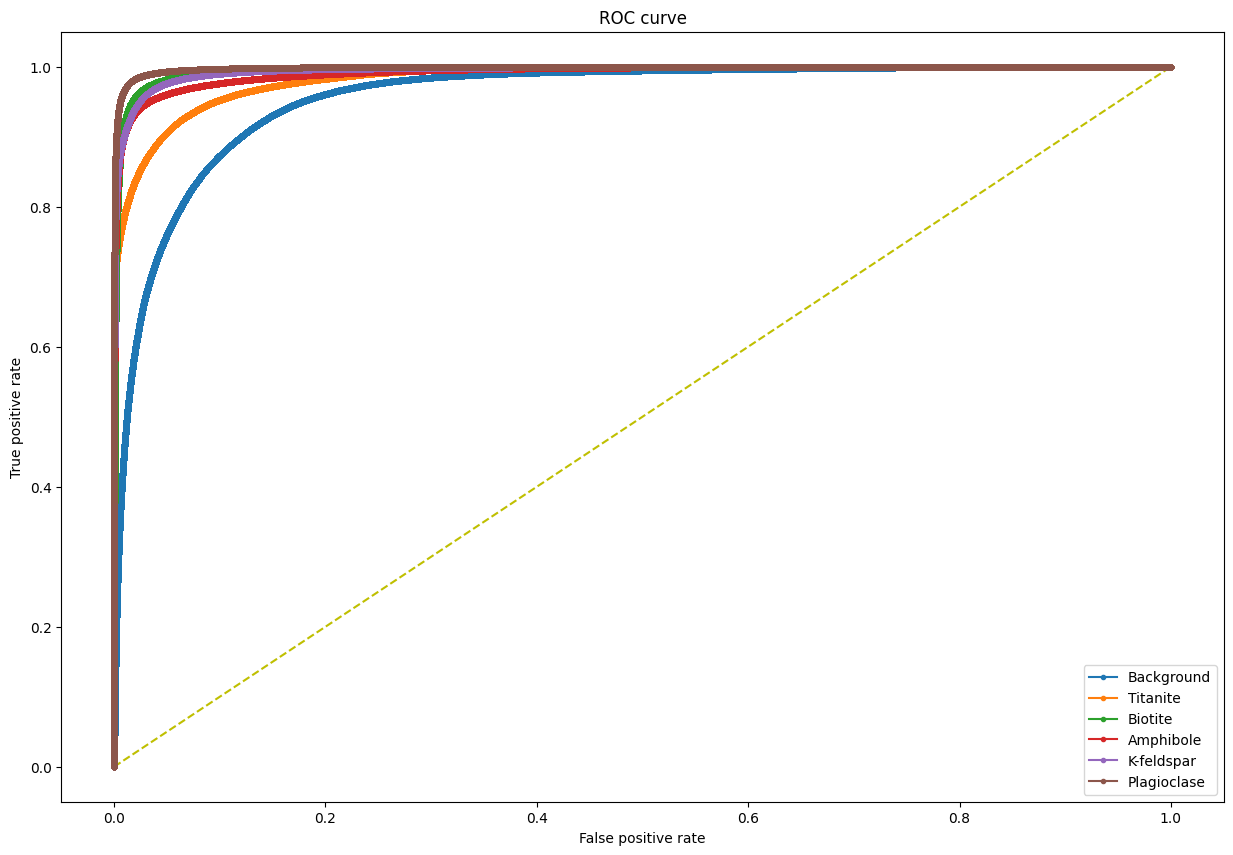

In [ ]:
#Plotting

plt.figure(1, figsize=(15,10))
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr0, tpr0, marker='.', label='Background')
plt.plot(fpr1, tpr1, marker='.', label='Titanite')
plt.plot(fpr2, tpr2, marker='.', label='Biotite')
plt.plot(fpr3, tpr3, marker='.', label='Amphibole')
plt.plot(fpr4, tpr4, marker='.', label='K-feldspar')
plt.plot(fpr5, tpr5, marker='.', label='Plagioclase')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

AUC

In [ ]:
from sklearn.metrics import roc_auc_score

auc0 = roc_auc_score(y_test_lin0, y_pred_lin0)
auc1 = roc_auc_score(y_test_lin1, y_pred_lin1)
auc2 = roc_auc_score(y_test_lin2, y_pred_lin2)
auc3 = roc_auc_score(y_test_lin3, y_pred_lin3)
auc4 = roc_auc_score(y_test_lin4, y_pred_lin4)
auc5 = roc_auc_score(y_test_lin5, y_pred_lin5)

print("AUC-ROC for Class 0:", auc0)
print("AUC-ROC for Class 1:", auc1)
print("AUC-ROC for Class 2:", auc2)
print("AUC-ROC for Class 3:", auc3)
print("AUC-ROC for Class 4:", auc4)
print("AUC-ROC for Class 5:", auc5)

AUC-ROC for Class 0: 0.9580097960029472
AUC-ROC for Class 1: 0.9841408950241468
AUC-ROC for Class 2: 0.9952790034193956
AUC-ROC for Class 3: 0.9914676906877914
AUC-ROC for Class 4: 0.9946332830487123
AUC-ROC for Class 5: 0.9980672912962879


Métricas do ChatGPT

In [ ]:
import numpy as np
from keras.metrics import MeanIoU
from keras.metrics import Precision, Recall
from keras.metrics import Accuracy
from keras.metrics import binary_accuracy
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical

# Função para calcular a métrica Intersection over Union (IoU)
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Função para calcular o coeficiente DICE
def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

In [ ]:
# Converte as máscaras para one-hot encoding
y_true = to_categorical(y_test_cat, num_classes=6)
y_pred = to_categorical(y_pred, num_classes=6)

# Número de classes
num_classes = y_true.shape[2]


In [ ]:
# Calcula as métricas para o modelo
iou = calculate_iou(y_true, y_pred)
dice = calculate_dice(y_true, y_pred)

NameError: ignored

In [ ]:
# Métricas do Keras
mean_iou = MeanIoU(num_classes=num_classes)
mean_iou.update_state(y_true, y_pred)
precision = Precision()
precision.update_state(y_true, y_pred)
recall = Recall()
recall.update_state(y_true, y_pred)
accuracy = Accuracy()
accuracy.update_state(y_true, y_pred)
binary_acc = binary_accuracy(y_true, y_pred)
categorical_acc = categorical_accuracy(y_true, y_pred)

In [ ]:
# Exibe as métricas calculadas para o modelo
print("Model Metrics:")
print("IoU:", iou)
print("DICE Coefficient:", dice)
print("Mean IoU (Keras):", mean_iou.result().numpy())
print("Precision (Keras):", precision.result().numpy())
print("Recall (Keras):", recall.result().numpy())
print("Accuracy (Keras):", accuracy.result().numpy())
#print("Binary Accuracy (Keras):", binary_acc.numpy())
#print("Categorical Accuracy (Keras):", categorical_acc.numpy())

Model Metrics:
IoU: 0.7142857142857143
DICE Coefficient: 0.8333333333333334
Mean IoU (Keras): 0.5493562
Precision (Keras): 0.8333333
Recall (Keras): 0.8333333
Accuracy (Keras): 0.9444444


In [ ]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection + 1e-7) / (union + 1e-7)

n_classes = 6

# Calculate Dice coefficient for all classes
dice_general = dice_coefficient(y_test.flatten(), y_pred.flatten())

print("Dice coefficient (general) =", dice_general)

# Calculate Dice coefficient for each class
dice_classes = []
for i in range(n_classes):
    dice_class = dice_coefficient(y_test[:,:,:,i].flatten(), y_pred[:,:,:,i].flatten())
    dice_classes.append(dice_class)
    print("Dice coefficient for class", i+1, "=", dice_class)

Dice coefficient (general) = 0.6364503936740141


IndexError: ignored